## Train Modified Model -- Development of a Transaction Categorization Model with Increased Importance for Clothing

This notebook aims to recreate the model to categorize transactions, with a difference: the clothing category should be prioritized.

There are some options to perform the prioritization:
 - Increase class weight importance for model training.
 - Adjust the class probability for the model prediction after it was created.
 - Perform error analysis to understand what might be reducing the class prediction performance or create new features to allow the model to better identify how to train the class.
 - Create synthetic records based on real records to provide more examples during the training.
 - Identify unlabelled data that has a high probability of being of the class and include them as positive examples for the model.
 
For this experiment, only the weight importance increase will be explored, considering the restricted time available to perform the experiments. Also, as the sample size is limited, any results will lack real relevance.

### Tasks:
 - [X] Load training dataset.
 - [X] Create k folds for experiments.
 - [X] Generate feature vector.
 - [X] For a set of `clothing` category weight adjustment options:
     - [X] Train model.
         - [X] Adjust weights.
         - [X] Increase `clothing` category weight.
         - [X] Compute metrics based on folds.
 - [X] Compute metrics based on weight adjustment options.
 - [X] Selected weight adjustment.
 - [X] Analyze fold results for an adjustment option.
 - [X] Train final model.
 - [X] Submit model, parameters and metrics do MLflow.

## Libraries and Configurations

In [1]:
import copy
from operator import itemgetter

import pandas as pd
from lightgbm.sklearn import LGBMClassifier

import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature


import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML

from application.code.core.configurations import configs
from application.code.adapters.storage import read_dataset
from application.code.core.dataset_split_service import generate_folds, describe_datasets
from application.code.core.feature_engineering import engineer_features, standardize_labels
from application.code.core.model_training_service import train_model
from application.code.core.model_training import (clean_data,
                                                  vectorize_folds,
                                                  compute_weights,
                                                  adjust_weights,
                                                  generate_encoders,
                                                  vectorize_dataset,
                                                  combine_feature_columns)
from application.code.core.model_evaluation import (compute_multiclass_classification_metrics,
                                                    generate_classification_report,
                                                    generate_feature_importance_report,
                                                    generate_confusion_matrix_report,
                                                    generate_labels_support,
                                                    plot_folds_metrics)
from application.code.adapters.mlflow_adapter import (log_dataframe_artifact, 
                                                      get_mlflow_artifact_content,
                                                      log_model,
                                                      register_model,
                                                      publish_model)
from application.code.core.financial_classification_model import FinancialClassificationModel

sns.set_style("whitegrid")

## Constants

This notebook shares the same constants from the Base Model experiment, except for the addition of `WEIGHT_ADJUSTMENT_OPTIONS` constant. This constant contains a range of values that increases the `clothing` category weight, making the records from this category have an additional effect on the model learning.

In [2]:
BASE_MODEL_PARAMS = {
    'objective': 'multiclass', 
    'metric': 'multi_error',
    'verbosity': -1, 
    'n_estimators': 500,
    'random_state': configs.model_training.model_seed,
    'deterministic': True
}

TARGET_COLUMN = 'grupo_estabelecimento'

CATEGORICAL_COLUMNS = ['cidade', 'estado', 'sexo', 
                       'cidade_estabelecimento','pais_estabelecimento']

HIGH_CARDINALITY_CATEGORICAL_COLUMNS = [
    'cidade', 'estado', 
    'cidade_estabelecimento', 'pais_estabelecimento', 'estado_estabelecimento',
]

BINARY_COLUMNS = ['sexo',  'dia_util',
                  'cidade_diferente', 'estado_diferente', 'pais_diferente',]

NUMERIC_COLUMNS = ['idade',
                   'limite_total', 'limite_disp', 'valor', 
                   'dia_semana', 'dia_mes', 'mes',
                   'valor_relativo_total', 'valor_relativo_disponivel',
                  ]

COLUMNS_SELECTION  = combine_feature_columns(HIGH_CARDINALITY_CATEGORICAL_COLUMNS,
                                             BINARY_COLUMNS,
                                             NUMERIC_COLUMNS)


WEIGHT_ADJUSTMENT_OPTIONS = [1, 1.5, 2, 2.5, 3, 5, 10, 
                             15, 20, 30, 50, 100, 150, 200]

EXPERIMENT_RUN_NAME = 'Modified Model'

## MLflow Settings

In [3]:
mlflow.set_tracking_uri(configs.mlflow.uri)
mlflow.set_experiment(configs.mlflow.experiment_name);

## Load Dataset

The `training` dataset is loaded to create the model and perform experiments.

In [4]:
df = read_dataset(base_path=configs.datasets.base_path, stage='raw', file_name='train')

display(HTML('<h4>Dataset</h4>'))
print(f'Records: {len(df)}')

Records: 3944


Split `training` set into a set of `training` and `validation` folds.

In [5]:
folds = generate_folds(df,
                       n_folds=configs.model_training.folds,
                       min_validation_size=configs.model_training.min_validation_size,
                       seed=configs.model_training.data_seed)

## Dataset Preprocessing and Feature Vectorization

Vectorization of each fold.

In [6]:
vectorized_folds = vectorize_folds(folds,
                                   columns_selection=COLUMNS_SELECTION,
                                   categorical_columns=CATEGORICAL_COLUMNS,
                                   high_cardinality_categorical_columns=HIGH_CARDINALITY_CATEGORICAL_COLUMNS,
                                   binary_columns=BINARY_COLUMNS,
                                   target_column=TARGET_COLUMN,
                                  )

## Model Training on Folds

### Hyperparameers Tunning and on Folds

As we want to explore different values for weight increase, the use of the k folds created is suitable to have an idea of the variance of the performance metrics and avoid indirectly overfitting on the `test` set.

In [7]:
%%time

model_params = copy.deepcopy(BASE_MODEL_PARAMS)

iterations_tracking = []
resources = []

for clothing_adjustment in WEIGHT_ADJUSTMENT_OPTIONS:

    weights_adjustments = {'vestuário': clothing_adjustment}

    for ix, ((train_X, train_y), (valid_X, valid_y), labels) in enumerate(vectorized_folds):

        class_weights = compute_weights(train_y)
        class_weights = adjust_weights(class_weights, labels, weights_adjustments)

        model_params.update({'class_weight': class_weights,
                             'num_class': len(set(train_y))})

        model = LGBMClassifier(**model_params)
        model.fit(train_X, train_y)

        preds = model.predict(valid_X)
        eval_metrics = compute_multiclass_classification_metrics(valid_y, 
                                                                 preds)
        
        classification_report_df = generate_classification_report(valid_y, preds, labels)
        clothing_f1 = classification_report_df.to_dict()['f1-score'].get('vestuário', 0)

        iteration_tracking = {**{'Fold': ix,
                                 'training_size': train_X.shape[0],
                                 'validation_size': valid_X.shape[0],
                                 'clothing_adjustment': clothing_adjustment,
                                 'clothing_f1': clothing_f1
                                },
                              **eval_metrics}
        iterations_tracking.append(iteration_tracking)    

        resources.append({'model': model,
                          'preds': preds,
                          'y': valid_y,
                          'labels': labels,
                          'clothing_adjustment': clothing_adjustment
                         })

CPU times: user 43min 4s, sys: 21.5 s, total: 43min 25s
Wall time: 5min 40s


#### Visualize Weights Effects over the Performance Metrics

As every set of k-folds is used to perform an experiment using a different `clothing adjustment`, it is necessary to group all experiments based on this value and extract statistics.

In [8]:
folds_evaluation_df = pd.DataFrame(iterations_tracking)

weight_adjustment_df = (
    folds_evaluation_df
    .groupby(['clothing_adjustment'])
    .median()
)

weight_adjustment_df

,Fold,training_size,validation_size,clothing_f1,macro_precision,macro_recall,macro_f1,micro_precision,micro_recall,micro_f1,weighted_precision,weighted_recall,weighted_f1
clothing_adjustment,,,,,,,,,,,,,
1.0,2.0,2679.0,425.0,0.162162,0.294384,0.273871,0.283400,0.423529,0.423529,0.423529,0.441805,0.423529,0.423123
1.5,2.0,2679.0,425.0,0.142857,0.286330,0.268014,0.261428,0.425882,0.425882,0.425882,0.414529,0.425882,0.410920
2.0,2.0,2679.0,425.0,0.093023,0.268984,0.261799,0.248775,0.425882,0.425882,0.425882,0.421641,0.425882,0.418014
2.5,2.0,2679.0,425.0,0.150000,0.269522,0.262378,0.255734,0.418824,0.418824,0.418824,0.428706,0.418824,0.415451
3.0,2.0,2679.0,425.0,0.150000,0.257511,0.267399,0.249688,0.440367,0.440367,0.440367,0.428613,0.440367,0.427332
5.0,2.0,2679.0,425.0,0.137931,0.274973,0.271178,0.268525,0.431193,0.431193,0.431193,0.426418,0.431193,0.419140
10.0,2.0,2679.0,425.0,0.127660,0.296937,0.286041,0.282128,0.428235,0.428235,0.428235,0.439593,0.428235,0.424641
15.0,2.0,2679.0,425.0,0.212766,0.272732,0.281294,0.258132,0.425882,0.425882,0.425882,0.434344,0.425882,0.422821
20.0,2.0,2679.0,425.0,0.181818,0.277098,0.275015,0.267602,0.423529,0.423529,0.423529,0.431968,0.423529,0.421469


A simple strategy to identify a value for the weight increase proportion is identifying the weight that increases the `vestuário` class performance and does not have a big impact on the `F1` performance computed for all classes.
`F1` was chosen to guide the `vestuário` class performance to be sure that we are not sacrificing `recall` to have a good `precision`. It is possible to have a notion of this aspect by analyzing the precision-recall curve for the class, but `F1` was selected due to its simplicity.

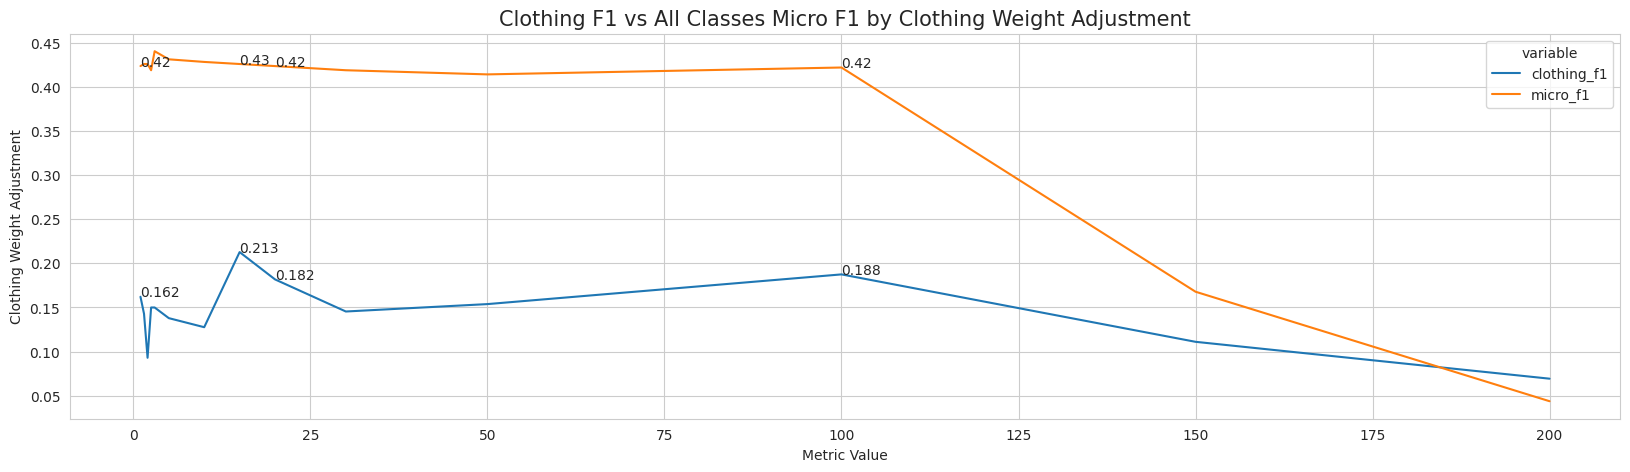

In [9]:
melted_results_df = (
    weight_adjustment_df
    .reset_index()
    [['clothing_adjustment', 'clothing_f1', 'micro_f1']]
    .melt(id_vars=['clothing_adjustment'], value_vars=['clothing_f1', 'micro_f1'])
)

plt.figure(figsize=configs.plots.small_fig_size)
ax = sns.lineplot(x="clothing_adjustment", y="value", hue="variable", data=melted_results_df)
ax.set_title(
    f"Clothing F1 vs All Classes Micro F1 by Clothing Weight Adjustment",
    fontdict={"fontsize": configs.plots.font_size},
)
ax.set_xlabel("Metric Value")
ax.set_ylabel("Clothing Weight Adjustment")


top_melted_results_df = (
    melted_results_df
    .loc[lambda f: f['variable'] == 'clothing_f1']
    .sort_values(by='value', ascending=False)    
    .groupby('variable')
    .head(4)
    .reset_index()
)

for item in top_melted_results_df.itertuples():
    ax.annotate(f'{item.value:.3}', xy=(item.clothing_adjustment, item.value))
    micro_f1_value = (
        melted_results_df
        .loc[lambda f: f['variable'] == 'micro_f1']
        .loc[lambda f: f['clothing_adjustment'] == item.clothing_adjustment]
        ['value']
        .iloc[0]
    )
    ax.annotate(f'{micro_f1_value:.2}', xy=(item.clothing_adjustment, micro_f1_value))
    
plt.show()

Based on the plot, *the clothing weight adjustment value selected was `15`*.  It increases the original F1 median by `~31.2%` (from `0.162` to `0.212`) with a decrease of `~0.55%` (from `0.425` to `0.423`) on the overall micro F1 performance.

### Folds Metrics

The results for the largest fold will be presented below.

,Fold,training_size,validation_size,clothing_adjustment,clothing_f1,macro_precision,macro_recall,macro_f1,micro_precision,micro_recall,micro_f1,weighted_precision,weighted_recall,weighted_f1
35,0,3533,411,15.0,0.212766,0.138492,0.129026,0.127260,0.391727,0.391727,0.391727,0.376574,0.391727,0.377397
36,1,3108,425,15.0,0.260870,0.310767,0.290260,0.293203,0.425882,0.425882,0.425882,0.434344,0.425882,0.422821
37,2,2679,429,15.0,0.117647,0.297821,0.310865,0.292366,0.405594,0.405594,0.405594,0.399814,0.405594,0.400309
38,3,2243,436,15.0,0.150943,0.272732,0.258765,0.258132,0.440367,0.440367,0.440367,0.440836,0.440367,0.431252
39,4,1826,417,15.0,0.235294,0.267022,0.281294,0.252244,0.465228,0.465228,0.465228,0.460782,0.465228,0.453753


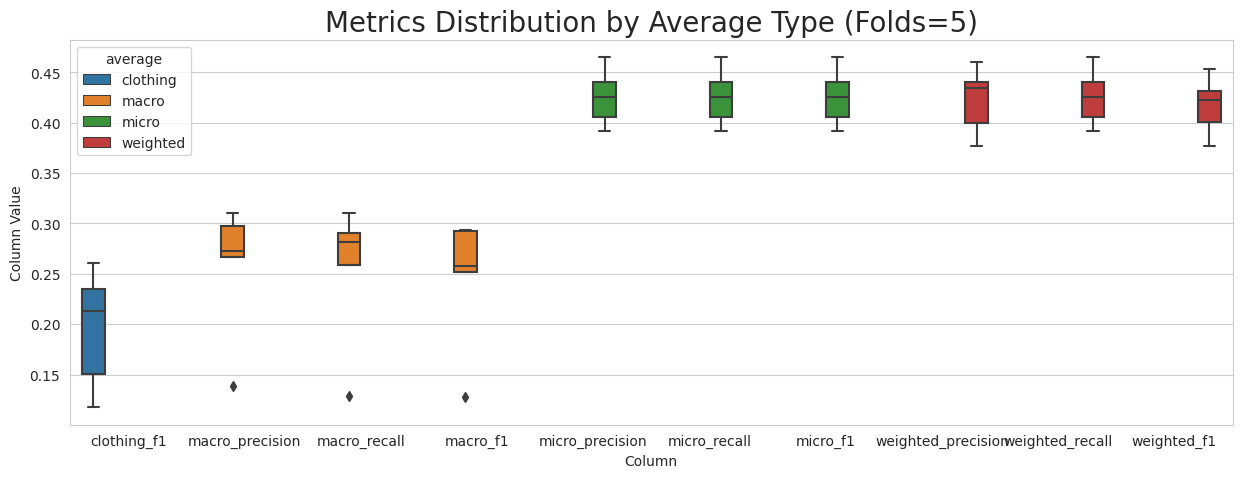

,mean,std
clothing_adjustment,15.000000,0.000000
clothing_f1,0.195504,0.059584
macro_precision,0.257367,0.068827
macro_recall,0.254042,0.072344
macro_f1,0.244641,0.068290
micro_precision,0.425760,0.028879
micro_recall,0.425760,0.028879
micro_f1,0.425760,0.028879
weighted_precision,0.422470,0.033786
weighted_recall,0.425760,0.028879


In [10]:
folds_evaluation_df = pd.DataFrame(iterations_tracking).query('clothing_adjustment == 15')

display(HTML('<h4>Individual Folds Results</h4>'))
display(folds_evaluation_df)

plot_folds_metrics(folds_evaluation_df)

display(HTML('<strong>Summarized Fold Metrics</strong>'))
summarized_validation_metrics_df = (
    folds_evaluation_df
    .drop(columns=['Fold', 'training_size', 'validation_size'])
    .agg(['mean', 'std'])
    .T
)
display(summarized_validation_metrics_df)

### Detailing Largets Fold Results

#### Model Performance per Class

In [11]:
folds_evaluation_df

,Fold,training_size,validation_size,clothing_adjustment,clothing_f1,macro_precision,macro_recall,macro_f1,micro_precision,micro_recall,micro_f1,weighted_precision,weighted_recall,weighted_f1
35,0,3533,411,15.0,0.212766,0.138492,0.129026,0.127260,0.391727,0.391727,0.391727,0.376574,0.391727,0.377397
36,1,3108,425,15.0,0.260870,0.310767,0.290260,0.293203,0.425882,0.425882,0.425882,0.434344,0.425882,0.422821
37,2,2679,429,15.0,0.117647,0.297821,0.310865,0.292366,0.405594,0.405594,0.405594,0.399814,0.405594,0.400309
38,3,2243,436,15.0,0.150943,0.272732,0.258765,0.258132,0.440367,0.440367,0.440367,0.440836,0.440367,0.431252
39,4,1826,417,15.0,0.235294,0.267022,0.281294,0.252244,0.465228,0.465228,0.465228,0.460782,0.465228,0.453753


In [12]:
selected_fold = 0
selected_resource = [ix 
                     for ix, r in enumerate(resources) 
                     if r['clothing_adjustment'] == 15][selected_fold]

fold_train_df, _ = folds[selected_fold]
fold_y, fold_preds, fold_labels = itemgetter('y', 'preds', 'labels')(resources[selected_resource])

training_support_df = generate_labels_support(fold_train_df).set_index('grupo_estabelecimento')

classification_report_df = generate_classification_report(fold_y, fold_preds, fold_labels)
(
    classification_report_df
    .join(training_support_df)
    .rename(columns={'support': 'validation_support'})
    .astype({'validation_support': int})
    .sort_values(by='training_support', ascending=False)
    .reset_index()
    .rename(columns={'index': 'class'})
    .style
    .applymap(lambda value: 'background-color:#7fb3d5' if value  > .5 else '',
              subset=['f1-score', 'precision', 'recall'])
    .applymap(lambda value: 'background-color:#d2b4de' if value  == 'vestuário' else '',
             subset=['class'])
    .applymap(lambda value: 'font-weight:bold', subset=['class'])
)

,class,precision,recall,f1-score,validation_support,training_support
0,serviço,0.648276,0.717557,0.681159,131,1324
1,restaurante,0.367647,0.367647,0.367647,68,640
2,varejo,0.181818,0.142857,0.160000,56,391
3,supermercados,0.227273,0.300000,0.258621,50,327
4,vestuário,0.172414,0.277778,0.212766,18,179
5,farmácias,0.000000,0.000000,0.000000,15,150
6,posto de gás,0.666667,0.235294,0.347826,17,141
7,compra online,0.269231,0.368421,0.311111,19,123
8,artigos eletro,0.375000,0.300000,0.333333,10,85
9,loja de departamento,0.000000,0.000000,0.000000,9,55


The precision for `vestuário` increased from `0.157895` to `0.172414` with respect to the standard class weight.

### Confusion Matrix

This section shows the confusion matrix for the top 10 classes (based on frequency).

In [13]:
top_labels_df = (df
 .pipe(clean_data, ['grupo_estabelecimento'])  
 [['grupo_estabelecimento']]
 .assign(records=1)
 .groupby('grupo_estabelecimento')
 .sum()
 .reset_index()
 .sort_values(by='records', ascending=False)
 .head(10)
)

display(HTML(f'<strong>Confusion Matrix for Top 10 Categories based on Model for Fold <code>{selected_fold}</code></strong>'))
confusion_matrix_df = generate_confusion_matrix_report(fold_y, fold_preds, fold_labels)

top_labels = set(top_labels_df['grupo_estabelecimento'].tolist())
top_rows_index = sorted(list(top_labels & set(confusion_matrix_df.index)))
top_columns_index = sorted(list(top_labels & set(confusion_matrix_df.columns.tolist())))

(
    confusion_matrix_df
    .loc[top_rows_index, top_columns_index]
)

,artigos eletro,compra online,farmácias,loja de departamento,posto de gás,restaurante,serviço,supermercados,varejo,vestuário
artigos eletro,3,1,0,0,0,1,4,0,0,1
compra online,1,7,1,0,0,1,1,4,1,3
farmácias,0,0,0,0,0,1,5,5,4,0
loja de departamento,0,1,0,0,0,1,3,2,2,0
posto de gás,0,0,1,1,4,3,1,7,0,0
restaurante,0,1,3,0,0,25,11,15,5,6
serviço,1,0,4,1,0,13,94,7,8,3
supermercados,1,2,0,0,1,9,8,15,11,3
varejo,1,8,1,0,0,10,13,8,8,6
vestuário,0,4,0,0,1,2,3,1,2,5


As the confusion matrix shows, the absolute gain over the results is not significant, due to the dataset limitations. The strategy could have a more concrete result and analysis with larger sample size.

## Main Model Training

This section creates the final model, using the entire `training` set. The final evaluation will be performed in another notebook, to avoid reusing the `test` set.

In [14]:
%%time


weights_adjustments = {'vestuário': 15}

clean_df = (
    df
    .drop_duplicates()
    .pipe(clean_data, CATEGORICAL_COLUMNS + [TARGET_COLUMN])
    .pipe(engineer_features)
)

labels = clean_df[TARGET_COLUMN].unique().tolist()

label_encoder, categorical_encoder = generate_encoders(
    clean_df[COLUMNS_SELECTION],
    labels,
    HIGH_CARDINALITY_CATEGORICAL_COLUMNS,
)

X_training, y_training = vectorize_dataset(df,
                                           label_encoder, 
                                           categorical_encoder,
                                           columns_selection=COLUMNS_SELECTION,
                                           categorical_columns=CATEGORICAL_COLUMNS,
                                           binary_columns=BINARY_COLUMNS,
                                           target_column=TARGET_COLUMN,
                                          )

model_params = copy.deepcopy(BASE_MODEL_PARAMS)

extra_artifacts = [
    (confusion_matrix_df, 'validation folds', 'confusion matrix'),
    (summarized_validation_metrics_df, 'validation folds', 'metrics')
]

mlflow_run, model = train_model(
    algorithm_class=LGBMClassifier,
    model_params=model_params,
    X_training=X_training,
    y_training=y_training,
    experiment_run_name=EXPERIMENT_RUN_NAME,
    extra_artifacts=extra_artifacts,
    features_names=COLUMNS_SELECTION,
    labels=labels,
    weights_adjustments=weights_adjustments
)

CPU times: user 52.8 s, sys: 538 ms, total: 53.3 s
Wall time: 7.89 s


### Model Registration and Publication

After creating the model, it is wrapped into an MLFlow class to be used later.

In [15]:
mlflow_model = FinancialClassificationModel(
    categorical_columns=CATEGORICAL_COLUMNS,
    binary_columns=BINARY_COLUMNS,
    numeric_columns=NUMERIC_COLUMNS,
    label_encoder=label_encoder,
    categorical_encoder=categorical_encoder,
    model=model)

Then, the model should be logged into the experiment, registered at the MLflow Registry and published with the `Staging` tag.

In [16]:
log_model(mlflow_model, mlflow_run, configs.mlflow.modified_model_name)
model_version = register_model(mlflow_run, configs.mlflow.modified_model_name)
publish_model(model_name=configs.mlflow.modified_model_name, 
              model_version=model_version, 
              stage="Staging")

2022/08/28 10:00:50 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: modified_financial_categorization_model, version 2


### Model Artifacts

A set of reports are saved on MLFlow to track the experiment. As the final assessment will be performed only at the end, the metrics are computed based on the training data. While it is not a good indicator of the generalization capacity of the model, it helps validate that the model is able to learn the patterns from the training set. It is expected that almost all metrics will have a perfect score, especially when using a boosting algorithm.

In [17]:
main_model_artifacts = get_mlflow_artifact_content(mlflow_run.info.run_id, 'main model')

for artifact_name, content in main_model_artifacts.items():
    display(HTML(f'<h4>{artifact_name.capitalize()}</h4>'))
    display(HTML(main_model_artifacts[artifact_name]))

,feature,absolute_importance,relative_importance
16,valor,27767,17.30%
10,limite_disp,22425,13.97%
18,valor_relativo_total,22124,13.78%
17,valor_relativo_disponivel,21773,13.56%
3,dia_mes,17301,10.78%
12,mes,10031,6.25%
4,dia_semana,9088,5.66%
2,cidade_estabelecimento,9043,5.63%
9,idade,8118,5.06%
11,limite_total,7095,4.42%


,metric,value
0,macro_precision,1.0
1,macro_recall,1.0
2,macro_f1,1.0
3,micro_precision,1.0
4,micro_recall,1.0
5,micro_f1,1.0
6,weighted_precision,1.0
7,weighted_recall,1.0
8,weighted_f1,1.0


,class,weight
0,0,31.301587
1,1,187.809524
2,2,1.976942
3,3,15.650794
4,4,6.260317
5,5,1.322602
6,6,17.073593
7,7,11.738095
8,8,8.943311
9,9,37.561905


,precision,recall,f1-score,support
serviço,1.0,1.0,1.0,6.0
farmácias,1.0,1.0,1.0,1.0
compra online,1.0,1.0,1.0,95.0
artigos eletro,1.0,1.0,1.0,12.0
varejo,1.0,1.0,1.0,30.0
loja de departamento,1.0,1.0,1.0,142.0
vestuário,1.0,1.0,1.0,165.0
móveis e decoração,1.0,1.0,1.0,16.0
hospitais e clínicas,1.0,1.0,1.0,21.0
sem ramo,1.0,1.0,1.0,5.0


## Concluding Remarks

 The approach developed to improve results for a specific class (`vestuário`) was increasing the weight importance of the class. As mentioned in the introduction, there are other approaches that could be combined to increase the model's precision. They were only mentioned due to time and sample size restrictions.
 
 The weight increase chosen by experimentation was `15`. It resulted in the increase of the class F1 by `~31.2%` (from `0.162` to `0.212`) with a decrease of `~0.55%` (from `0.425` to `0.423`) in the micro F1 performance for all classes.